In [11]:
# Load and clean data
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Read the file
data_act = pd.read_csv('PCA.txt',sep=',',header=0)
data_act = data_act.drop(columns=['Unnamed: 0'])
data_act = data_act.drop(columns=['PC4','PC5','PC6','PC7','PC8','PC9','PC10', 'PC11','PC12'])
display(data_act)

,PC1,PC2,PC3,sequence_name,activity
0,2.617548,1.325635,-0.292061,A01,walking
1,2.620493,1.326871,-0.295911,A01,walking
2,2.635749,1.323256,-0.288440,A01,walking
3,2.651102,1.324907,-0.257815,A01,walking
4,2.659644,1.296632,-0.224235,A01,walking
...,...,...,...,...,...
164855,0.672865,0.755559,-0.281320,E05,walking
164856,0.696968,0.749089,-0.266641,E05,walking
164857,0.697832,0.683410,-0.232985,E05,walking
164858,0.681272,0.626271,-0.224052,E05,walking


In [3]:
# We split the data using whole groups of sequences (A01+A02+---A05, B01+....+B05 etc).
# The next two lines were used to single out a sequence
import random
random.seed(55)
print(random.randint(1, 5))
# The number one correlates with the letter A.
data_act['sequence_name'].unique()


1


array(['A01', 'A02', 'A03', 'A04', 'A05', 'B01', 'B02', 'B03', 'B04',
       'B05', 'C01', 'C02', 'C03', 'C04', 'C05', 'D01', 'D02', 'D03',
       'D04', 'D05', 'E01', 'E02', 'E03', 'E04', 'E05'], dtype=object)

In [12]:
# Split into training and test set

from sklearn.model_selection import train_test_split
import numpy as np
import random

# We split our data based on the results from the cell above. All A01-A05 sequences are selected. 
# Roughly 20% of our data.
train_data_act = data_act[data_act['sequence_name'].isin(['B01', 'B02', 'B03', 'B04',
       'B05', 'C01', 'C02', 'C03', 'C04', 'C05', 'D01', 'D02', 'D03',
       'D04', 'D05', 'E01', 'E02', 'E03', 'E04', 'E05'])]
test_data_act = data_act[data_act['sequence_name'].isin(['A01', 'A02', 'A03', 'A04', 'A05'])]


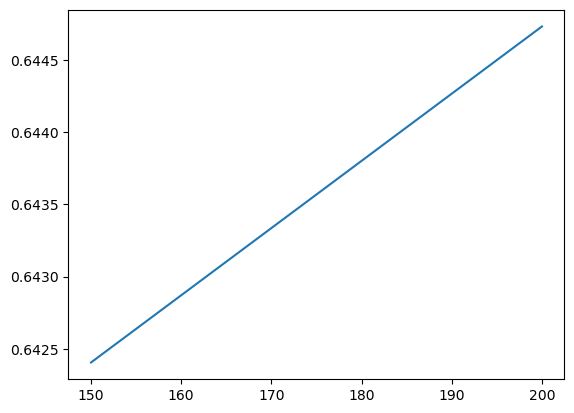

 Best K is:  200  has value:  0.6447325327502615


In [15]:
# Selecting parameters using cross validation
# Each function takes training, traines and testes and presents the accuracy. If we can feed it 
# If it can take the whole training set AND the sequences that should be used for test that would be great.
# It should return a print.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def fold_creator(training_data_frame, test_sequence):
    '''Takes a data_frame and a sequence (B01, B02 etc) and return a list with X and y for train and test.
    index position 0=X_train, 1=y_train, 2=X_test, 3=y_test in the returned list'''
   
    train_data_act = training_data_frame[training_data_frame['sequence_name'].isin(test_sequence)]
    test_data_act = training_data_frame[~training_data_frame.sequence_name.str.contains('|'.join(test_sequence))]
    
    y_train = train_data_act['activity'] 
    X_train = train_data_act

    y_test = test_data_act['activity'] 
    X_test = test_data_act


    # Drop unnecessary data for X
    column_list = ['sequence_name', 'activity']
    for element in column_list:
        X_train = X_train.drop(element, axis=1)
        X_test = X_test.drop(element, axis=1)
    
    
    
    list_w_X_and_y = [X_train, y_train, X_test, y_test]
    return list_w_X_and_y
    

def accuracy_finder(list_w_X_and_y, k_value_list):
    '''Takes an X_train and a y_train and a y_test and a list of k_values and returns an array w their accuracies'''
    list_of_accuracies = []
    
    for k_value in k_value_list:
        # Traines a knn model
        knn = KNeighborsClassifier(n_neighbors=k_value)
        knn.fit(list_w_X_and_y[0], list_w_X_and_y[1])

        # Return accuracy
        predictions_generalization = knn.predict(list_w_X_and_y[2])


        list_of_accuracies.append(accuracy_score(list_w_X_and_y[3], predictions_generalization))
    return np.array(list_of_accuracies)

def accuracy_ploter_master(data_frame, k_value_list):
    '''Master function that creates lists of accuracies, weighs them together and plots them. '''
     # We start by creating our for folds and puting them in a list
    fold_list = []
    fold_list.append( fold_creator(data_frame, ['B01', 'B02', 'B03', 'B04', 'B05']) )
    fold_list.append(fold_creator(data_frame, ['C01', 'C02', 'C03', 'C04', 'C05']))
    fold_list.append(fold_creator(data_frame, ['D01', 'D02', 'D03', 'D04', 'D05']))
    fold_list.append(fold_creator(data_frame, ['E01', 'E02', 'E03', 'E04', 'E05']))
    # We then calculate all accuracies and create a list that holds all accuracy arrays
    list_w_accuracies = []
    for fold in fold_list:
        list_w_accuracies.append(accuracy_finder(fold, k_value_list))
    
    # The next step is to add all accuracies together
    weighed_together_accuracies = (list_w_accuracies[0] + list_w_accuracies[1] + list_w_accuracies[2] + list_w_accuracies[3]) / 4
    list_of_weighed_values = weighed_together_accuracies.tolist()
    max_value = max(list_of_weighed_values)
    plt.plot(k_value_list, list_of_weighed_values)
    
    plt.show()
    print(' Best K is: ', k_value_list[list_of_weighed_values.index(max_value)], ' has value: ', max_value)
    

#k_values_to_test = np.arange(150, 250, 100).tolist()
k_values_to_test = np.array([150, 200])

accuracy_ploter_master(train_data_act, k_values_to_test)


In [13]:
# Fit model
from sklearn.neighbors import KNeighborsClassifier

y_train = train_data_act['activity'] 
X_train = train_data_act # Note that this still contains activity and such is really the whole train data frame, not just the X part

y_test = test_data_act['activity'] 
X_test = test_data_act # Note that this still contains activity and such is really the whole test data frame, not just the X part


# We drop unwanted columns from X
column_list = ['sequence_name', 'activity']
for element in column_list:
    X_train = X_train.drop(element, axis=1)
    X_test = X_test.drop(element, axis=1) # This is where we drop the labels (activity)


knn = KNeighborsClassifier(n_neighbors=200)
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=200)

                                        precision    recall  f1-score   support

                               falling       0.19      0.18      0.19       446
                                 lying       0.87      0.87      0.87     10597
                            lying down       0.15      0.16      0.16       811
                          on all fours       0.74      0.29      0.41      1176
                               sitting       0.81      0.68      0.74      5051
                          sitting down       0.00      0.00      0.00       263
                 sitting on the ground       0.79      0.80      0.79      2373
                standing up from lying       0.47      0.38      0.42      2492
              standing up from sitting       0.29      0.01      0.03       147
standing up from sitting on the ground       0.26      0.07      0.12       472
                               walking       0.46      0.79      0.58      3645

                              accuracy

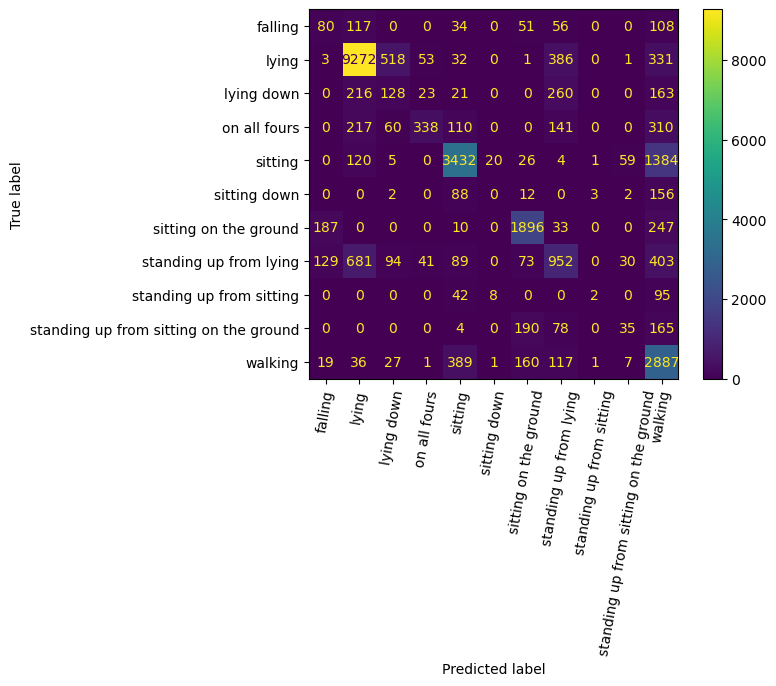

In [14]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import warnings

# Evluation
predictions = knn.predict(X_test) # This is where we calculate our prediction


confusion = confusion_matrix(y_test, predictions, labels=knn.classes_)
print(classification_report(y_test, knn.predict(X_test)))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=knn.classes_)
disp.plot()
plt.xticks(rotation=80)
plt.show()
